O framework que usaremos nessas aulas e projetos é o **Medipipe** (desenvolvido pelo Google). Nessa aula estudaremos o rastreamento de mão, onde há dois módulos: detecção da palma e landmarks. O primeiro módulo retorna a imagem da mão para a detecção das landmarks e as landmarks, por sua vez, retornam os pontos-chaves da mão.

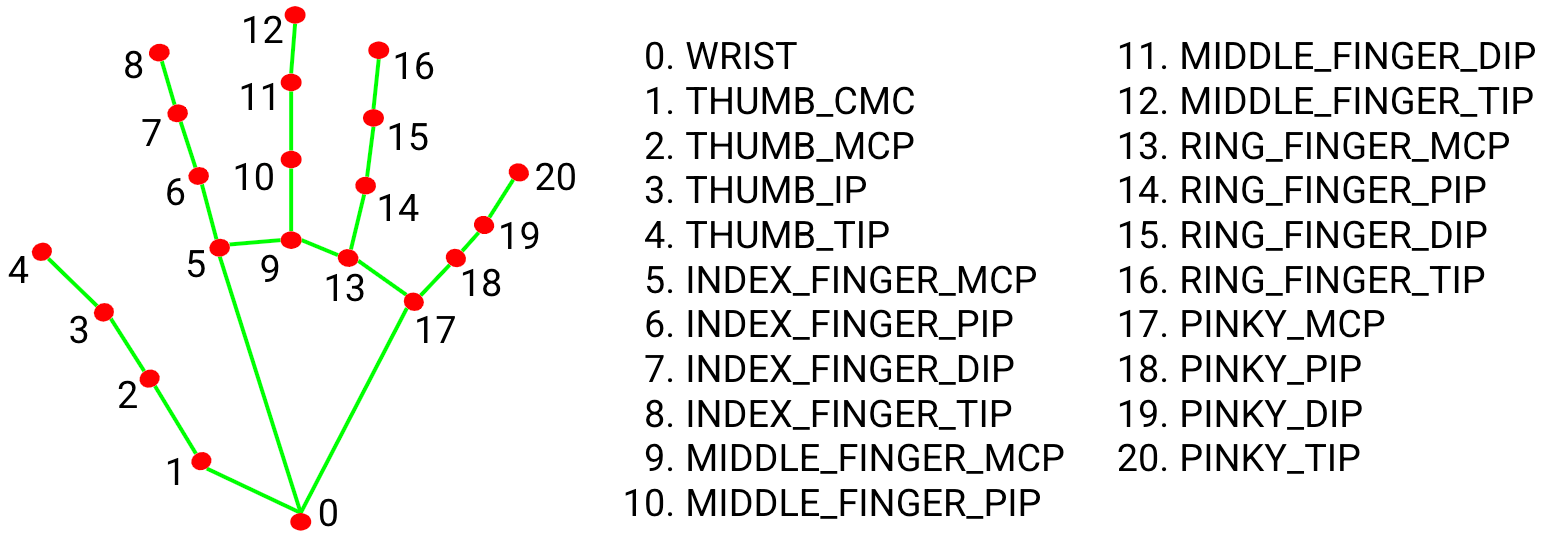

Para pegar todos esses pontos-chaves das nãos, foram analisadas manualmente mais de 30 mil diferentes mãos. Foi m trabalho longo e cansativo, mas por conta desse trabalho é que o Mediapipe funciona tão bem. A grande maravilha dessa biblioteca é que ela é multiplataforma e simples de se implementada no código.

Vamos para o código!

Antes de começar efetivamente, devemos instalar duas bibliotecas: a Mediapipe e a OpenCV. Para isso, faremos de duas maneiras. A primeira é usando o **pip** no prompt de comando:
- Para o Mediapipe: `pip install mediapipe`
- Para o OpenCV: `pip install opencv-python`

Se você estiver usando o Jupyter pode fazer isso dentro de uma célula de comando, basta colocar um ponto de exclamação (!) no começo:
- Para o Mediapipe: `!pip install mediapipe`
- Para o OpenCV: `!pip install opencv-python`

### Importar as bibliotecas

In [1]:
import cv2  # OpenCV
import mediapipe as mp  # Mediapipe
import time  # usada para verificar o FPS

### Criar um módulo

Vamos criar alguns módulos para que fique mais fácil de fazer o código e mais legível (além de evitar bugs).

In [45]:
# Mãos
mpMaos = mp.solutions.hands
maos = mpMaos.Hands()

# Desenhar as landmarks
mp_desenho = mp.solutions.drawing_utils

Vamos saber o que tem dentro desse nosso módulo *maos* criado. Para isso, basta colocar dois pontos de interrogação (??) antes do módulo que abrirá uma janela com o código fonte.

In [19]:
??maos

Há quatro parâmetros em nosso módulo *maos*, vamos ver o que fazem:
- `static_image_mode`: Se definido como **False**, este parâmetro detectara as mãos nas primeiras capturas, e se forem bem sucedidas, começa o processo de rastreamento. As imagens capturadas subsequentemente não serão mais detectadas, mas sim rastradas através do landmarks. A detecção só será feita novamente se o parâmetro perder a referência das mãos. Se definido como **True**, a detecção ocorre a cada captura de imagem, é ideal usar para um lote de imagens estáticas, pois usado para captura de vídeo, deixará o processo muito lento. O padrão é **False**.
- `max_num_hands`: Informa o número de mãos a serem detectadas. O padrão é **2**.
- `min_detection_confidence`: Valor de confiança mínimo entre 0 e 1 para que a detecção seja considerável confiável. O padrão é **0.5**.
- `min_tracking_confidence`: Valor de confiança mínimo entre 0 e 1 para que o rastreamento seja registrado. Caso o valor retornado seja menor do que o solicitado, na próxima captura de vídeo será feito a detecção automaticamente. Se `static_image_mode` for **True**, esse valor de confiança é descartado. O padrão é **0.5**.

Não vamos precisar mudar os valores dos parâmetros, já que os usaremos assim.

### Taxa de frame (FPS)

O FPS é a taxa de quantas fotos está sendo mostrada por segundo. No meu caso, ficou entre 25 e 30 FPS; mas esse valor varia muito de câmera para câmera.

In [47]:
tempo_anterior = 0
tempo_atual = 0

### Captura de vídeo

Nesta etapa, vamos habilitar a câmera com o OpenCV para realizar as capturas de imagem. A câmera padrão usada é a 0 (webcam), mas pode ser outra que esteja acoplada ao computador. Pode também ser usado o nome da câmera se preferir, para isso basta consultar a documentação do OpenCV.

In [58]:
cap = cv2.VideoCapture(0)

while True:
    sucesso, imagem = cap.read()
    
    # Converter a cor da imagem (o Mediapipe usa somente imagens em RGB e o OpenCV captura em BGR)
    imagem_rgb = cv2.cvtColor(imagem, cv2.COLOR_BGR2RGB)
    
    # Resultado do processamento da imagem
    resultados = maos.process(imagem_rgb)
    
    # Colocar as landmarks na mão
    if resultados.multi_hand_landmarks:
        for mao_landmark in resultados.multi_hand_landmarks:
            for landmark in mao_landmark.landmark:
                # vamos verificar a posição em pixel dentro na tela das landmarks
                altura, largura, centro = imagem.shape
                cx, cy = int(landmark.x*largura), int(landmark.y*altura)
                # para todas as landmarks vamos fazer um círculo em volta dela
                # só é possível os círculos seguirem as landmarks porque estamos passando a posição do eixo X e Y
                # em ordem: a imagem que será colocada o círculo, a posição do centro do círculo, raio, cor e preenchimento
                cv2.circle(imagem, (cx, cy), 15, (255, 0, 0), cv2.FILLED)
            # passar a imgem original (sem conversão), pois é ela que é mostrada na tela
            # passar o parâmetro mao_landmark mostrará as landmarks das mãos
            # passar o parâmetro .HAND_CONNECTIONS mostrará as conexões entre os landmarks
            # o primeiro mp_desenho.DrawingSpec são para os landmarks
            # o segundo mp_desenho.DrawingSpec são para as conexões
            mp_desenho.draw_landmarks(imagem, mao_landmark, mpMaos.HAND_CONNECTIONS,
                                     mp_desenho.DrawingSpec(color=(0, 0, 255)),
                                     mp_desenho.DrawingSpec(color=(0, 255, 0)))
            
    # Configurar o FPS da captura
    tempo_atual = time.time()
    fps = 1 / (tempo_atual - tempo_anterior)
    tempo_anterior = tempo_atual
    
    # Colcar o valor de FPS na tela
    # em ordem: a iamgem que será colocado o texto, o texto, a posição na imagem, fonte, tamanho, cor e largura
    cv2.putText(imagem, str(int(fps)), (10, 70), cv2.FONT_HERSHEY_PLAIN, 3, (255, 0, 255), 3)
    
    # Mostrar a imagem na tela
    cv2.imshow('Imagem', imagem)
    
    # Terminar o loop
    if cv2.waitKey(1) & 0xFF == ord('s'):
        break
    
# Fechar a tela de captura
cap.release()
cv2.destroyAllWindows()